In [1]:
# Initial imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
from pathlib import Path
import requests

%matplotlib inline

In [2]:
MSFT_csv = Path("../SaaS_Data/Microsoft_MSFT.csv")

In [3]:
MSFT_df = pd.read_csv(MSFT_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [4]:
MSFT_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-08-13,289.48,292.90,289.30,292.85,"18,249,051"
2021-08-12,286.63,289.97,286.34,289.81,"14,570,390"
2021-08-11,287.21,288.66,285.86,286.95,"13,955,930"
2021-08-10,288.80,289.25,285.20,286.44,"18,616,580"
2021-08-09,289.75,291.55,287.81,288.33,"16,117,630"


In [5]:
MSFT_df.sort_index(ascending=True, inplace=True)

In [6]:
MSFT_df = MSFT_df.rename(columns={'Close': 'Close'})
MSFT_df = MSFT_df[['Close']]
MSFT_df

,Close
Date,
2020-08-13,208.70
2020-08-14,208.90
2020-08-17,210.28
2020-08-18,211.49
2020-08-19,209.70
...,...
2021-08-09,288.33
2021-08-10,286.44
2021-08-11,286.95


In [7]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window-1):
        features = df.iloc[i : (i+window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
window_size = 100
feature_column = 0
target_column = 0

X, y = window_data(MSFT_df, window_size, feature_column, target_column)

print(f"X sample values:\n{X[:3]} \n")
print(f"y sample values:\n{y[:3]}")

X sample values:
[[208.7  208.9  210.28 211.49 209.7  214.58 213.02 213.69 216.47 221.15
  226.58 228.91 225.53 227.27 231.65 217.3  214.25 202.66 211.29 205.37
  204.03 205.41 208.78 205.05 202.91 200.39 202.54 207.42 200.59 203.19
  207.82 209.44 207.26 210.33 212.46 206.19 210.38 205.91 209.83 210.58
  215.81 221.4  222.86 220.86 219.66 219.66 214.22 214.65 214.8  214.89
  216.23 210.08 213.25 202.68 204.72 202.47 202.33 206.43 216.39 223.29
  223.72 218.39 211.01 216.55 215.44 216.51 217.23 214.46 211.08 212.42
  210.39 210.11 213.86 213.87 215.23 214.07 216.21 215.37 214.24 214.36
  214.29 216.01 211.8  210.52 213.26 214.2  214.13 219.28 219.42 218.59
  222.59 223.94 221.02 222.75 224.96 224.15 221.68 222.42 217.69 217.9 ]
 [208.9  210.28 211.49 209.7  214.58 213.02 213.69 216.47 221.15 226.58
  228.91 225.53 227.27 231.65 217.3  214.25 202.66 211.29 205.37 204.03
  205.41 208.78 205.05 202.91 200.39 202.54 207.42 200.59 203.19 207.82
  209.44 207.26 210.33 212.46 206.19 210.38 20

In [9]:
split = int(0.6 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [10]:
y_train

array([[212.25],
       [218.29],
       [219.62],
       [217.49],
       [214.93],
       [216.34],
       [213.02],
       [212.65],
       [216.44],
       [224.34],
       [224.97],
       [225.95],
       [229.53],
       [232.33],
       [232.9 ],
       [238.93],
       [231.96],
       [239.65],
       [239.51],
       [243.  ],
       [242.01],
       [242.2 ],
       [242.47],
       [243.77],
       [242.82],
       [244.49],
       [244.99],
       [243.7 ],
       [244.2 ],
       [243.79],
       [240.97],
       [234.51],
       [233.27],
       [234.55],
       [228.99],
       [232.38],
       [236.94],
       [233.87],
       [227.56],
       [226.73],
       [231.6 ],
       [227.39],
       [233.78],
       [232.42],
       [237.13],
       [235.75],
       [234.81],
       [237.71],
       [237.04],
       [230.72],
       [230.35],
       [235.99],
       [237.58],
       [235.46],
       [232.34],
       [236.48],
       [235.24],
       [231.85],
       [235.77

In [11]:
# Import MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

x_train_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()

x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

X_test = x_train_scaler.transform(X_test)
y_test = y_train_scaler.transform(y_test)

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [14]:
model = Sequential()

number_units = window_size
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape= (X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True
    ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units
    ))
model.add(Dropout(dropout_fraction))

# Output Layer
model.add(Dense(1))

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [16]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=100, verbose=1)

Epoch 1/20
1/1 [==============================] - 6s 6s/step - loss: 0.4189
Epoch 2/20
1/1 [==============================] - 0s 310ms/step - loss: 0.2807
Epoch 3/20
1/1 [==============================] - 0s 325ms/step - loss: 0.1820
Epoch 4/20
1/1 [==============================] - 0s 309ms/step - loss: 0.0794
Epoch 5/20
1/1 [==============================] - 0s 300ms/step - loss: 0.0438
Epoch 6/20
1/1 [==============================] - 0s 331ms/step - loss: 0.1173
Epoch 7/20
1/1 [==============================] - 0s 287ms/step - loss: 0.0678
Epoch 8/20
1/1 [==============================] - 0s 267ms/step - loss: 0.0398
Epoch 9/20
1/1 [==============================] - 0s 293ms/step - loss: 0.0463
Epoch 10/20
1/1 [==============================] - 0s 303ms/step - loss: 0.0620
Epoch 11/20
1/1 [==============================] - 0s 279ms/step - loss: 0.0653
Epoch 12/20
1/1 [==============================] - 0s 288ms/step - loss: 0.0596
Epoch 13/20
1/1 [==============================] - 0

In [17]:
model.evaluate(X_test, y_test, verbose=0)

0.09782080352306366

In [18]:
predicted = model.predict(X_test)

In [19]:
predicted_prices = y_train_scaler.inverse_transform(predicted)

In [20]:
real_prices = y_train_scaler.inverse_transform(y_test.reshape(-1,1))

In [21]:
MSFT_actual_predicted = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = MSFT_df.index[-len(real_prices): ])

MSFT_actual_predicted.head()

,Actual,Predicted
Date,,
2021-05-19,243.08,251.514664
2021-05-20,243.12,251.112991
2021-05-21,246.48,250.718842
2021-05-24,245.17,250.361145
2021-05-25,250.78,250.040283


In [22]:
MSFT_actual_predicted.tail()

,Actual,Predicted
Date,,
2021-08-09,289.46,266.489655
2021-08-10,288.33,266.666718
2021-08-11,286.44,266.835571
2021-08-12,286.95,266.986389
2021-08-13,289.81,267.115143


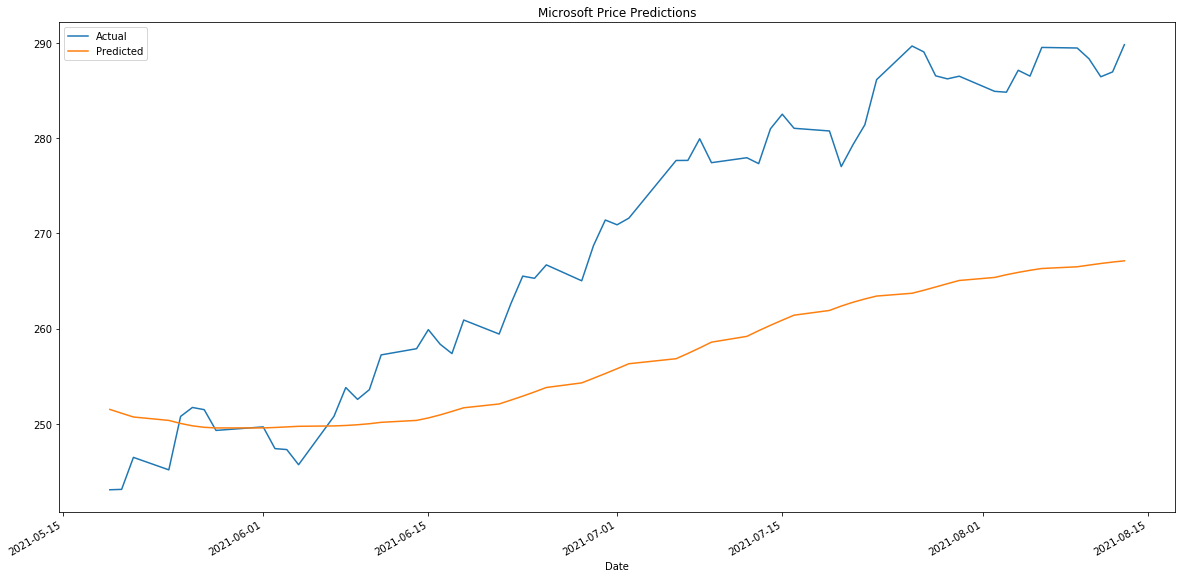

In [23]:
MSFT_actual_predicted.plot(figsize=(20,10), title="Microsoft Price Predictions")